In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [54]:
k = 10

In [55]:
# Функции f, g и точное решение u_exact
def f(x, y):
    return 2 * k * k * torch.sin(k * x) * torch.cos(k * y)

def g(x, y):
    return torch.sin(k * x) * torch.cos(k * y)

def u_exact(x, y):
    return torch.sin(k * x) * torch.cos(k * y)

In [56]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [57]:
# Класс для семплирования точек внутри области и на границе
class PointSampler:
    def __init__(self, n_domain, n_boundary):
        self.n_domain = n_domain
        self.n_boundary = n_boundary

    def sample(self):
        # Семплирование точек внутри области
        x_domain = np.random.uniform(0, np.pi, (self.n_domain, 1))
        y_domain = np.random.uniform(0, np.pi, (self.n_domain, 1))
        domain_points = np.hstack((x_domain, y_domain))
        
        # Семплирование точек на границе
        x_b = np.random.uniform(0, np.pi, (self.n_boundary // 4, 1))
        y_b = np.zeros((self.n_boundary // 4, 1))
        bottom = np.hstack((x_b, y_b))
        
        y_b = np.full((self.n_boundary // 4, 1), np.pi)
        top = np.hstack((x_b, y_b))
        
        x_b = np.zeros((self.n_boundary // 4, 1))
        y_b = np.random.uniform(0, np.pi, (self.n_boundary // 4, 1))
        left = np.hstack((x_b, y_b))
        
        x_b = np.full((self.n_boundary // 4, 1), np.pi)
        right = np.hstack((x_b, y_b))
        
        boundary_points = np.vstack((bottom, top, left, right))
        
        return torch.tensor(domain_points, dtype=torch.float32), torch.tensor(boundary_points, dtype=torch.float32)

In [58]:
def compute_loss(model, domain_points, boundary_points):
    domain_points.requires_grad = True
    u = model(domain_points)
    
    grad_u = torch.autograd.grad(u, domain_points, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x, u_y = grad_u[:, 0:1], grad_u[:, 1:2]
    
    u_xx = torch.autograd.grad(u_x, domain_points, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(u_y, domain_points, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
    
    loss_pde = torch.mean((u_xx + u_yy + f(domain_points[:, 0:1], domain_points[:, 1:2])) ** 2)
    
    u_boundary = model(boundary_points)
    loss_bc = torch.mean((u_boundary - g(boundary_points[:, 0:1], boundary_points[:, 1:2])) ** 2)
    
    return loss_pde + loss_bc

In [62]:
# Обучение модели
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
sampler = PointSampler(n_domain=5000, n_boundary=1000)
loss_history = []

Epoch 0, Loss: 10129.833984375
Epoch 500, Loss: 10112.87109375
Epoch 1000, Loss: 9893.3466796875
Epoch 1500, Loss: 9759.7509765625
Epoch 2000, Loss: 9656.9775390625
Epoch 2500, Loss: 8680.0966796875
Epoch 3000, Loss: 9159.3671875
Epoch 3500, Loss: 8926.4189453125
Epoch 4000, Loss: 8974.3623046875
Epoch 4500, Loss: 9248.27734375
Epoch 5000, Loss: 7980.41015625
Epoch 5500, Loss: 7329.0634765625
Epoch 6000, Loss: 5778.68310546875
Epoch 6500, Loss: 5164.626953125
Epoch 7000, Loss: 4956.75048828125
Epoch 7500, Loss: 4637.8916015625
Epoch 8000, Loss: 3770.11572265625
Epoch 8500, Loss: 3236.8173828125
Epoch 9000, Loss: 2749.4111328125
Epoch 9500, Loss: 2346.028076171875
Epoch 10000, Loss: 1994.9063720703125
Epoch 10500, Loss: 1588.65185546875
Epoch 11000, Loss: 1262.9766845703125
Epoch 11500, Loss: 1083.559326171875
Epoch 12000, Loss: 777.6344604492188
Epoch 12500, Loss: 619.5387573242188
Epoch 13000, Loss: 532.95263671875
Epoch 13500, Loss: 381.9853210449219
Epoch 14000, Loss: 311.6324462890

In [65]:
for epoch in range(5000):
    optimizer.zero_grad()
    domain_points, boundary_points = sampler.sample()
    loss = compute_loss(model, domain_points.to(device), boundary_points.to(device))
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 114.89653778076172
Epoch 500, Loss: 57.38835144042969
Epoch 1000, Loss: 53.775634765625
Epoch 1500, Loss: 26.878576278686523
Epoch 2000, Loss: 16.194751739501953
Epoch 2500, Loss: 10.456974983215332
Epoch 3000, Loss: 9.339017868041992
Epoch 3500, Loss: 7.564512729644775
Epoch 4000, Loss: 7.399481773376465
Epoch 4500, Loss: 18.817611694335938


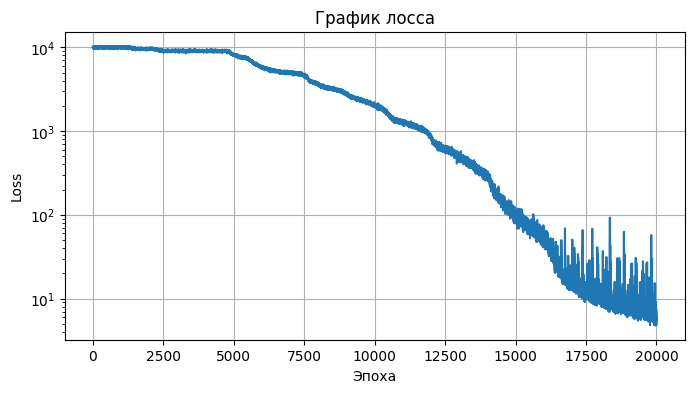

In [66]:
# Построение графика лосса
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("График лосса")
plt.grid()
plt.show()

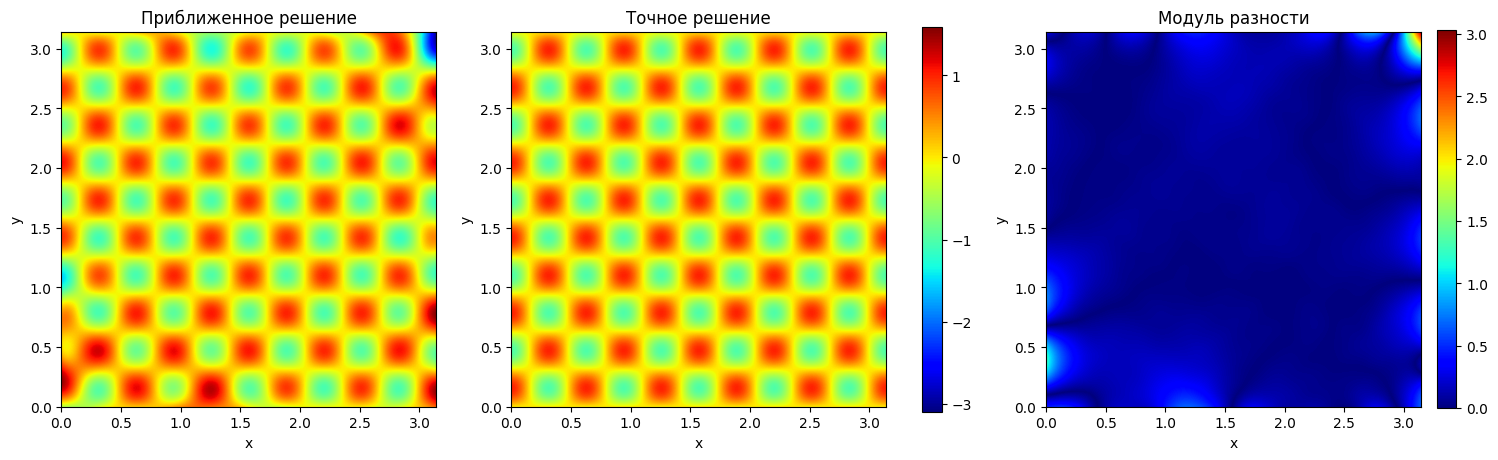

In [68]:
# Визуализация решения
x = torch.linspace(0, np.pi, 1000, device=device)
y = torch.linspace(0, np.pi, 1000, device=device)
X, Y = torch.meshgrid(x, y, indexing='ij')
points = torch.stack((X.flatten(), Y.flatten()), dim=1)
u_pred = model(points).detach().cpu().numpy().reshape(1000, 1000)
u_exact_vals = u_exact(X, Y).cpu().numpy().reshape(1000, 1000)
diff = np.abs(u_pred - u_exact_vals)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

vmin, vmax = min(u_pred.min(), u_exact_vals.min()), max(u_pred.max(), u_exact_vals.max())

im1 = axes[0].imshow(u_pred, extent=[0, np.pi, 0, np.pi], origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axes[0].set_title('Приближенное решение')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

im2 = axes[1].imshow(u_exact_vals, extent=[0, np.pi, 0, np.pi], origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axes[1].set_title('Точное решение')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

im3 = axes[2].imshow(diff, extent=[0, np.pi, 0, np.pi], origin='lower', cmap='jet')
axes[2].set_title('Модуль разности')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')

fig.colorbar(im1, ax=axes[:2], fraction=0.046, pad=0.04)
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.show()

